<a href="https://colab.research.google.com/github/Chris-Congleton/Chris-Congleton/blob/main/ReverbChannelTestData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora
from pprint import pprint


import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path_ftm = 'gdrive/MyDrive/CS/Thesis/rc_testdata/ftm-nl.article-cleansed-1000-articles.json'
path_joop = 'gdrive/MyDrive/CS/Thesis/rc_testdata/joop-bnnvara-nl.article-cleansed-1000-articles.json'
path_nos = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nos-nl.article-cleansed-1000-articles.json'
path_nu = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nu-nl.article-cleansed-1000-articles.json'
path_volkskrant = 'gdrive/MyDrive/CS/Thesis/rc_testdata/volkskrant-nl.article-cleansed-1000-articles.json'

In [4]:
df_ftm = pd.read_json(path_ftm)
df_joop = pd.read_json(path_joop)
df_nos = pd.read_json(path_nos)
df_nu = pd.read_json(path_nu)
df_volkskrant = pd.read_json(path_volkskrant)

In [5]:
df_ftm["Bron"] = "Follow The Money"
df_joop["Bron"] = "Joop"
df_nos["Bron"] = "NOS"
df_nu["Bron"] = "Nu"
df_volkskrant["Bron"] = "Volkskrant"

dfs = [df_joop, df_ftm, df_nos, df_nu, df_volkskrant]
df_all = pd.concat(dfs, ignore_index=True)

df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


In [6]:
df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


In [7]:
# Remove the columns
articles = df_all.drop(columns=['id', 'keywords',
                                'leading-image', 'leading-image-caption-content',
                                'leading-image-caption-source', 'leading-image-copyright',
                                'og-description', 'og-image', 'og-title',
                                'structure', 'url', 'html_raw', 'page_json',
                                'categories', 'cleaned'], axis=1)# Print out the first rows of papers
articles.head()

,cleantext,timestamp,title,Bron
0,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,Joop
1,In Frankrijk is ophef ontstaan rond kritiek op...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,Joop
2,Twee Franse academici zijn een petitie begonne...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,Joop
3,Foto: ANP | Sander Koning Het was afgelopen ma...,2019-04-14 09:12:48,Weglopen van de wegloper,Joop
4,Op 2 april 2019 was de opening van de Vrijheid...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,Joop


In [8]:
# Remove punctuation
articles['cleantext_processed'] = \
articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = \
articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-8-341723ed8bf8>:2: DeprecationWarning: invalid escape sequence \.
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))


0    hoe staat europa ervoor na w&eacute;&eacute;r ...
1    in frankrijk is ophef ontstaan rond kritiek op...
2    twee franse academici zijn een petitie begonne...
3    foto: anp | sander koning het was afgelopen ma...
4    op 2 april 2019 was de opening van de vrijheid...
Name: cleantext_processed, dtype: object

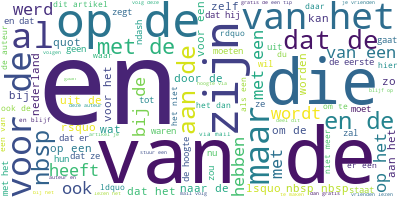

In [14]:
# Join the different processed titles together.
long_string = ','.join(list(articles['cleantext_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['staat', 'europa', 'ervoor', 'eacute', 'eacute', 'brexit', 'uitstel', 'vooravond', 'europese', 'verkiezingen', 'vanwege', 'uitstel', 'verenigd', 'koninkrijk', 'verplicht', 'mee', 'verkiezingen', 'betekent', 'verhoudingen', 'europees', 'parlement', 'ondanks', 'puinhoop', 'onzekerheid', 'naderende', 'brexit', 'verenigd', 'koninkrijk', 'meebrengt', 'klinkt']


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 2), (6, 5), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [19]:
# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"we" + 0.006*"jaar" + 0.004*"wel" + 0.003*"beeld" + 0.003*"weer" + '
  '0.003*"waar" + 0.002*"gaat" + 0.002*"nederland" + 0.002*"zegt" + '
  '0.002*"mensen"'),
 (1,
  '0.006*"we" + 0.005*"jaar" + 0.004*"wel" + 0.004*"beeld" + 0.003*"mensen" + '
  '0.003*"waar" + 0.003*"twee" + 0.003*"gaan" + 0.002*"gaat" + 0.002*"goed"'),
 (2,
  '0.005*"we" + 0.004*"jaar" + 0.003*"beeld" + 0.003*"wel" + 0.003*"nederland" '
  '+ 0.003*"waar" + 0.003*"moeten" + 0.002*"mensen" + 0.002*"zegt" + '
  '0.002*"gaan"'),
 (3,
  '0.004*"wel" + 0.004*"we" + 0.003*"mensen" + 0.002*"zegt" + 0.002*"jaar" + '
  '0.002*"waar" + 0.002*"goed" + 0.002*"nieuwe" + 0.002*"twee" + '
  '0.002*"alleen"'),
 (4,
  '0.008*"we" + 0.006*"wel" + 0.004*"jaar" + 0.003*"zegt" + 0.003*"twee" + '
  '0.003*"beeld" + 0.003*"gaat" + 0.003*"mensen" + 0.003*"waar" + 0.002*"the"'),
 (5,
  '0.006*"jaar" + 0.005*"we" + 0.004*"beeld" + 0.003*"waar" + 0.003*"twee" + '
  '0.003*"goed" + 0.002*"moeten" + 0.002*"gaat" + 0.002*"onderzoek"

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.003570 -0.007520       1        1  15.335587
7     -0.003914  0.003146       2        1  12.986327
13    -0.003615 -0.005914       3        1  12.133107
10    -0.005453 -0.001573       4        1  10.671358
9     -0.009159 -0.003133       5        1   7.425754
11     0.018311 -0.009811       6        1   6.313622
1     -0.006136 -0.004933       7        1   5.347855
8     -0.008210 -0.003096       8        1   5.224945
12    -0.001354  0.000345       9        1   4.721471
14     0.001546 -0.000742      10        1   4.384407
2     -0.001097 -0.006749      11        1   4.054860
6      0.008019  0.008087      12        1   3.565250
0     -0.003067  0.003374      13        1   3.315631
5     -0.004253  0.024254      14        1   2.327579
3      0.021952  0.004265      15        1   2.192247, topic_info=           Term         Freq        Total Category  logprob  loglift
219        jaar  5625.000000  5625.000000  Default  30.0000  30.0000
509          we  6669.000000  6669.000000  Default  29.0000  29.0000
423         wel  4958.000000  4958.000000  Default  28.0000  28.0000
1603      beeld  3432.000000  3432.000000  Default  27.0000  27.0000
74         waar  3119.000000  3119.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2222    volgens    39.336360  2321.067857  Topic15  -6.5228  -0.2574
287   nederland    40.273950  2631.412547  Topic15  -6.4993  -0.3593
1603      beeld    42.191431  3432.877191  Topic15  -6.4527  -0.5787
199       grote    37.459331  2067.676039  Topic15  -6.5717  -0.1907
264       maken    36.756874  2269.914314  Topic15  -6.5906  -0.3029

[1258 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
72946      5  0.673372  aalsmeerse
38337      3  0.576728    aanklikt
32115      1  0.175945       abbey
32115      2  0.219932       abbey
32115      4  0.043986       abbey
...      ...       ...         ...
82707      9  0.442723      zwenkt
18646      1  0.105605  zwerfafval
18646      2  0.633629  zwerfafval
18646      3  0.105605  zwerfafval
18646      5  0.105605  zwerfafval

[4262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 14, 11, 10, 12, 2, 9, 13, 15, 3, 7, 1, 6, 4])